<a href="https://colab.research.google.com/github/KIRTIRAJ4327/30days-AI-challenge/blob/main/Day28_Personalized_News_Curator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Core Concept:**

Content filtering and personalization techniques that balance personal interests while avoiding echo chambers.

**Here's a simple explanation of the Personalized News Curator with a brief example:**

The Personalized News Curator is like a smart news app that knows what topics you enjoy (like technology or sports) but also shows you different perspectives. Imagine you read mostly about technology innovations - our system would track this interest but also occasionally show you articles about tech regulations or criticisms. For example, if you've read five articles about new AI products, the system might show you four new AI articles you'd likely enjoy, but also include one about AI ethics concerns or regulations. This balance ensures you stay informed about your interests while still being exposed to the broader conversation, avoiding the "filter bubble" where you only see one perspective.

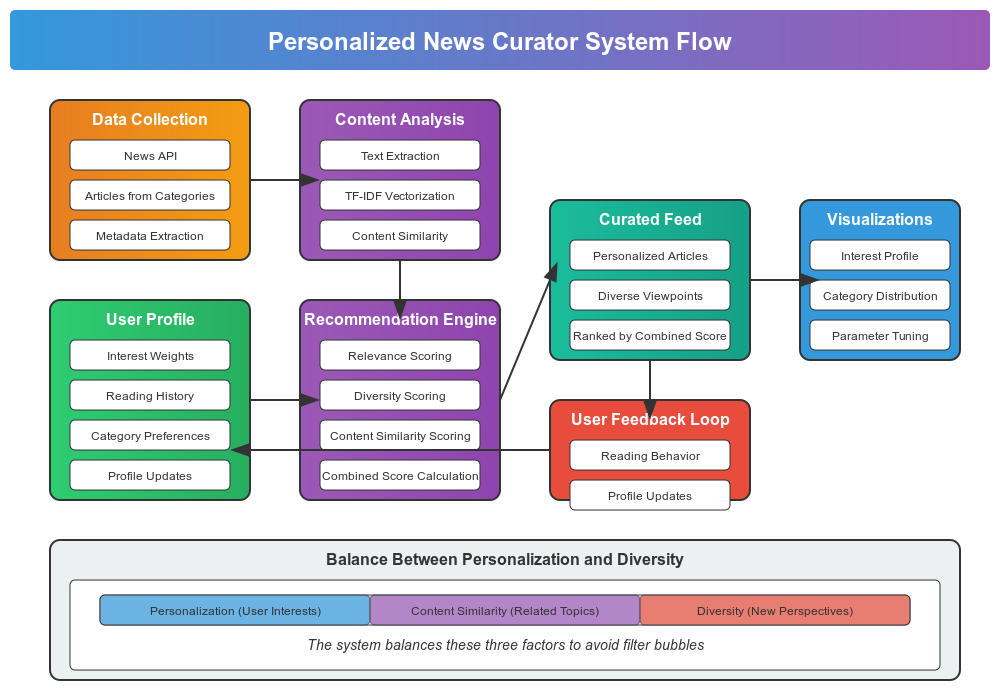

**Set Up Your Environment**

In [1]:
# Install required libraries
!pip install newsapi-python nltk scikit-learn pandas matplotlib

**Import Libraries and Set Up API Access**

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import random
import json
from newsapi import NewsApiClient
import datetime

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Initialize News API client (you'll need to get a free API key from newsapi.org)
# You can get a free API key by registering at: https://newsapi.org/register
api_key = "0fec2ad5dee944ce923306b01aa345c3"  # Replace with your actual API key
newsapi = NewsApiClient(api_key=api_key)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Fetch News Articles**

In [4]:
def fetch_news(categories=['business', 'technology', 'science', 'health', 'entertainment', 'sports']):
    """Fetch news articles from different categories"""
    all_articles = []

    # Get current date
    today = datetime.datetime.now().date()

    # Fetch articles from each category
    for category in categories:
        try:
            articles = newsapi.get_top_headlines(
                category=category,
                language='en',
                country='us',
                page_size=10  # Limit to 10 articles per category
            )

            # Add category to each article
            for article in articles['articles']:
                article['category'] = category
                all_articles.append(article)

        except Exception as e:
            print(f"Error fetching {category} news: {e}")

    # Convert to DataFrame for easier manipulation
    df = pd.DataFrame(all_articles)

    # Keep only relevant columns
    if not df.empty:
        df = df[['title', 'description', 'url', 'publishedAt', 'category']]

    return df

**Create a User Profile System**

In [5]:
class UserProfile:
    def __init__(self, user_id, initial_interests=None):
        """
        Initialize a user profile with optional initial interests

        Parameters:
        - user_id: Unique identifier for the user
        - initial_interests: Dictionary with categories as keys and interest weights as values
        """
        self.user_id = user_id

        # Default interests (equal weight to all categories)
        default_interests = {
            'business': 1.0,
            'technology': 1.0,
            'science': 1.0,
            'health': 1.0,
            'entertainment': 1.0,
            'sports': 1.0
        }

        # Use provided interests or defaults
        self.interests = initial_interests if initial_interests else default_interests

        # History of articles user has interacted with
        self.read_articles = []

    def update_interest(self, category, interaction_strength=0.1):
        """Update user's interest in a category based on interaction"""
        if category in self.interests:
            self.interests[category] += interaction_strength

    def record_article_read(self, article_id, category):
        """Record that user has read an article"""
        self.read_articles.append(article_id)
        self.update_interest(category)

    def get_interest_profile(self):
        """Get normalized interest profile"""
        total = sum(self.interests.values())
        normalized = {k: v/total for k, v in self.interests.items()}
        return normalized

**Implement Article Scoring and Recommendation**

In [6]:
def calculate_diversity_score(article, user_profile):
    """
    Calculate how diverse an article is relative to user's interests
    Higher score means it's in a category the user doesn't usually read
    """
    interests = user_profile.get_interest_profile()
    category = article['category']

    # Invert the interest score (less interest = higher diversity)
    if category in interests:
        return 1.0 - interests[category]
    else:
        return 0.5  # Default middle value for unknown categories

def calculate_relevance_score(article, user_profile):
    """
    Calculate how relevant an article is to user's interests
    Higher score means it's more aligned with their interests
    """
    interests = user_profile.get_interest_profile()
    category = article['category']

    # Return the interest score directly
    if category in interests:
        return interests[category]
    else:
        return 0.5  # Default middle value for unknown categories

def recommend_articles(articles_df, user_profile, num_recommendations=10, diversity_weight=0.3):
    """
    Recommend articles balancing user interests and diversity

    Parameters:
    - articles_df: DataFrame containing articles
    - user_profile: UserProfile object
    - num_recommendations: Number of articles to recommend
    - diversity_weight: How much to prioritize diversity (0-1)
    """
    if articles_df.empty:
        return pd.DataFrame()

    # Calculate relevance and diversity scores
    articles_df['relevance_score'] = articles_df.apply(
        lambda article: calculate_relevance_score(article, user_profile), axis=1)

    articles_df['diversity_score'] = articles_df.apply(
        lambda article: calculate_diversity_score(article, user_profile), axis=1)

    # Calculate combined score (weighted sum)
    relevance_weight = 1.0 - diversity_weight
    articles_df['combined_score'] = (
        relevance_weight * articles_df['relevance_score'] +
        diversity_weight * articles_df['diversity_score']
    )

    # Filter out articles user has already read
    unread_articles = articles_df[~articles_df.index.isin(user_profile.read_articles)]

    # Sort by combined score and get top recommendations
    recommendations = unread_articles.sort_values('combined_score', ascending=False).head(num_recommendations)

    return recommendations

**Create a Simple Demo of the System**

Fetching news articles...

--- Initial recommendations (exploration phase) ---
[BUSINESS] More alternatives to knee replacement surgery are emerging - The Washington Post
Relevance: 0.17, Diversity: 0.83
→ https://www.washingtonpost.com/health/2025/05/11/knee-arthritis-replacement-nerves-ablation/

[BUSINESS] Trump's trade war is giving renewed importance to advertising Upfronts - CNBC
Relevance: 0.17, Diversity: 0.83
→ https://www.cnbc.com/2025/05/11/advertising-upfronts-trump-trade-renewed-importance.html

[BUSINESS] Coinbase aims to become the No. 1 financial service app in the world in 10 years, CEO says - CNBC
Relevance: 0.17, Diversity: 0.83
→ https://www.cnbc.com/2025/05/11/coinbase-aims-to-be-worlds-number-1-financial-service-app-in-10-years.html

[BUSINESS] Reporter Unravels Why His Cancer Drug Costs So Much - Newser
Relevance: 0.17, Diversity: 0.83
→ https://www.newser.com/story/368385/reporter-unravels-why-his-cancer-drug-costs-so-much.html

[BUSINESS] A business owner teste

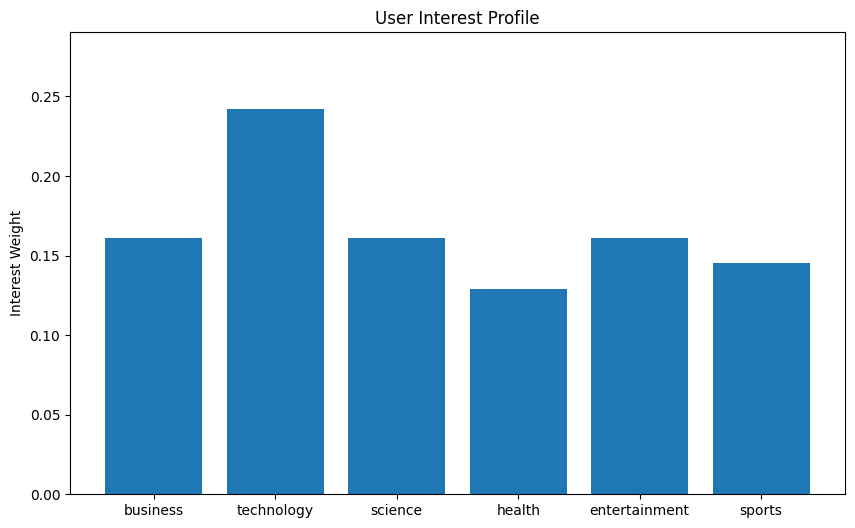

In [7]:
def run_news_curator_demo():
    """Run a demonstration of the personalized news curator"""
    # Create a user profile (with slight preference for technology)
    initial_interests = {
        'business': 1.0,
        'technology': 1.2,  # Slightly higher interest in technology
        'science': 1.0,
        'health': 0.8,
        'entertainment': 1.0,
        'sports': 0.9
    }
    user = UserProfile(user_id='demo_user', initial_interests=initial_interests)

    # Fetch news articles
    print("Fetching news articles...")
    articles = fetch_news()

    if articles.empty:
        print("No articles found. Please check your API key.")
        return

    # Get initial recommendations (higher diversity weight)
    print("\n--- Initial recommendations (exploration phase) ---")
    initial_recommendations = recommend_articles(
        articles, user, num_recommendations=5, diversity_weight=0.5)

    display_recommendations(initial_recommendations)

    # Simulate user reading some technology articles
    print("\n--- Simulating user reading technology articles ---")
    tech_articles = articles[articles['category'] == 'technology'].head(3)
    for i, article in tech_articles.iterrows():
        print(f"User read: {article['title']} (Technology)")
        user.record_article_read(i, 'technology')

    # Now get new recommendations (after user has shown technology preference)
    print("\n--- Updated recommendations ---")
    updated_recommendations = recommend_articles(
        articles, user, num_recommendations=5, diversity_weight=0.3)

    display_recommendations(updated_recommendations)

    # Show how interest profile changed
    print("\n--- User interest profile ---")
    print(user.get_interest_profile())

    # Plot the interest distribution
    plot_interest_profile(user)

def display_recommendations(recommendations):
    """Display recommended articles nicely"""
    if recommendations.empty:
        print("No recommendations available.")
        return

    for i, article in recommendations.iterrows():
        print(f"[{article['category'].upper()}] {article['title']}")
        print(f"Relevance: {article['relevance_score']:.2f}, Diversity: {article['diversity_score']:.2f}")
        print(f"→ {article['url']}\n")

def plot_interest_profile(user):
    """Visualize the user's interest profile"""
    interests = user.get_interest_profile()

    plt.figure(figsize=(10, 6))
    plt.bar(interests.keys(), interests.values())
    plt.title("User Interest Profile")
    plt.ylabel("Interest Weight")
    plt.ylim(0, max(interests.values()) * 1.2)
    plt.show()

# Run the demo
run_news_curator_demo()

**Add Content-Based Similarity to Improve Recommendations**

In [8]:
def extract_text_features(articles_df):
    """Extract features from article text using TF-IDF"""
    # Combine title and description for better feature extraction
    articles_df['content'] = articles_df['title'] + ' ' + articles_df['description'].fillna('')

    # Create TF-IDF vectors
    tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
    content_features = tfidf.fit_transform(articles_df['content'])

    return content_features, tfidf

def calculate_content_similarity(articles_df, read_indices):
    """Calculate similarity between articles based on content"""
    if articles_df.empty or not read_indices:
        return pd.Series(0.5, index=articles_df.index)  # Default similarity

    # Extract features
    content_features, _ = extract_text_features(articles_df)

    # Get features for read articles
    read_features = content_features[read_indices]

    # Calculate similarity to each read article
    similarities = cosine_similarity(content_features, read_features)

    # Take maximum similarity to any read article
    max_similarities = similarities.max(axis=1)

    return pd.Series(max_similarities, index=articles_df.index)

**Enhance Recommendation Function with Content Similarity**

In [9]:
def enhanced_recommend_articles(articles_df, user_profile, num_recommendations=10,
                              diversity_weight=0.3, content_weight=0.4):
    """
    Enhanced recommendation function that uses content similarity

    Parameters:
    - content_weight: How much to prioritize content similarity (0-1)
    """
    if articles_df.empty:
        return pd.DataFrame()

    # Calculate relevance and diversity scores
    articles_df['relevance_score'] = articles_df.apply(
        lambda article: calculate_relevance_score(article, user_profile), axis=1)

    articles_df['diversity_score'] = articles_df.apply(
        lambda article: calculate_diversity_score(article, user_profile), axis=1)

    # Calculate content similarity if user has read articles
    if user_profile.read_articles:
        read_indices = [i for i in user_profile.read_articles if i in articles_df.index]
        articles_df['content_similarity'] = calculate_content_similarity(articles_df, read_indices)
    else:
        articles_df['content_similarity'] = 0.5  # Default middle value

    # Calculate combined score (weighted sum of all factors)
    remaining_weight = 1.0 - (diversity_weight + content_weight)
    articles_df['combined_score'] = (
        remaining_weight * articles_df['relevance_score'] +
        diversity_weight * articles_df['diversity_score'] +
        content_weight * articles_df['content_similarity']
    )

    # Filter out articles user has already read
    unread_articles = articles_df[~articles_df.index.isin(user_profile.read_articles)]

    # Sort by combined score and get top recommendations
    recommendations = unread_articles.sort_values('combined_score', ascending=False).head(num_recommendations)

    return recommendations

**Run the Enhanced Personalized News Curator**

Fetching news articles...

--- Initial recommendations (exploration phase) ---
[HEALTH] Mom Rushed 1-Year-Old to the ER After He Showed Odd Symptoms. His 'Life-Changing' Diagnosis Shocked Her (Exclusive) - Yahoo
Relevance: 0.14, Diversity: 0.86, Content Similarity: 0.50
→ https://people.com/todder-rushed-to-the-hospital-diagnosed-with-type-1-diabetes-exclusive-11726632

[HEALTH] Measles Cases In The U.S. Just Hit 1,000. RFK Jr. Still Isn't Taking It Seriously. - HuffPost
Relevance: 0.14, Diversity: 0.86, Content Similarity: 0.50
→ https://www.huffpost.com/entry/us-measles-cases-1000-rfk-jr-hhs_n_681f8e4be4b0108bb6b70ed3

[HEALTH] Knowledge isn’t enough: What really predicts condom use in teens - PsyPost
Relevance: 0.14, Diversity: 0.86, Content Similarity: 0.50
→ https://www.psypost.org/knowledge-isnt-enough-what-really-predicts-condom-use-in-teens/

[HEALTH] The FDA approves first U.S. at-home tool as a Pap-smear alternative - NPR
Relevance: 0.14, Diversity: 0.86, Content Similarity: 

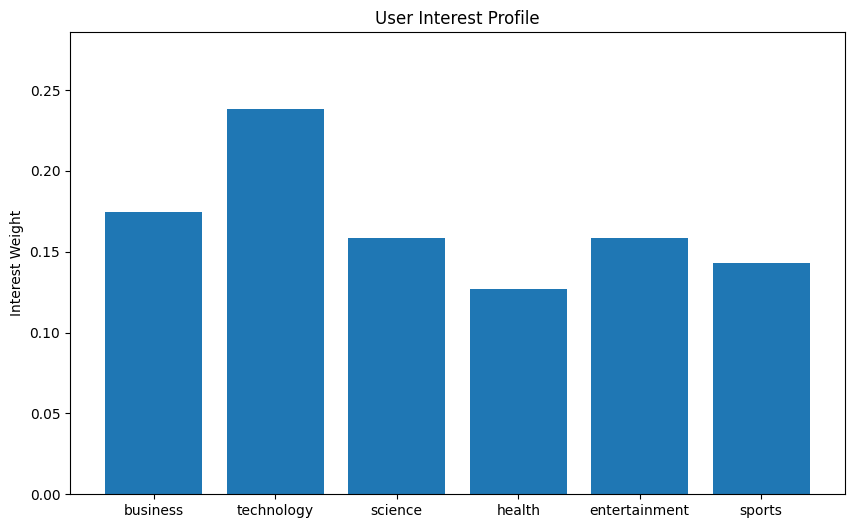


--- Category Distribution in Recommendations ---
business: 2 articles (40.0%)
sports: 1 articles (20.0%)
science: 1 articles (20.0%)
health: 1 articles (20.0%)


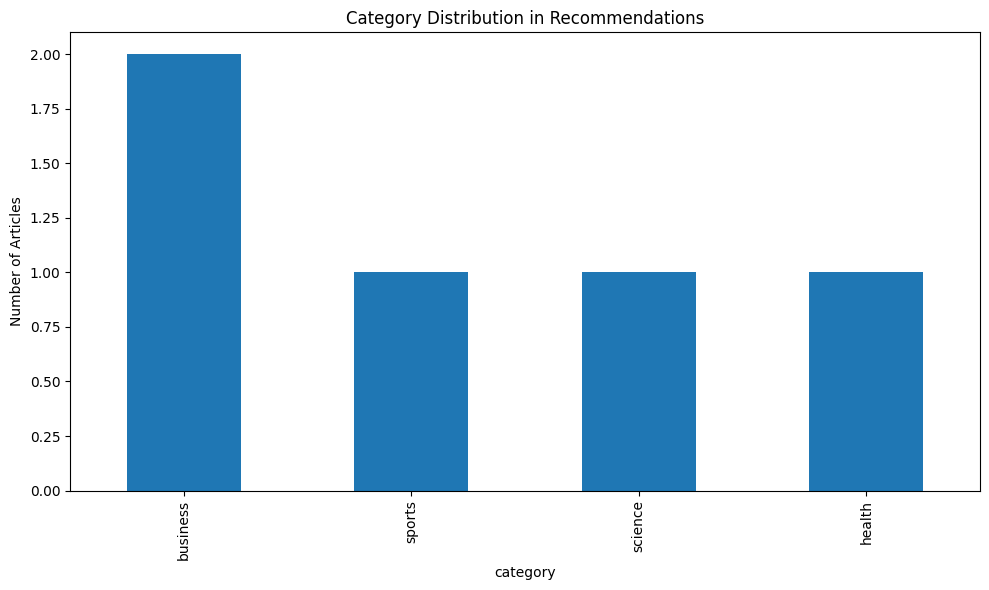

In [10]:
def run_enhanced_news_curator_demo():
    """Run a demonstration of the enhanced personalized news curator"""
    # Create a user profile (with slight preference for technology)
    initial_interests = {
        'business': 1.0,
        'technology': 1.2,  # Slightly higher interest in technology
        'science': 1.0,
        'health': 0.8,
        'entertainment': 1.0,
        'sports': 0.9
    }
    user = UserProfile(user_id='demo_user', initial_interests=initial_interests)

    # Fetch news articles
    print("Fetching news articles...")
    articles = fetch_news()

    if articles.empty:
        print("No articles found. Please check your API key.")
        return

    # Get initial recommendations (higher diversity weight)
    print("\n--- Initial recommendations (exploration phase) ---")
    initial_recommendations = enhanced_recommend_articles(
        articles, user, num_recommendations=5, diversity_weight=0.4, content_weight=0.3)

    display_enhanced_recommendations(initial_recommendations)

    # Simulate user reading some technology articles
    print("\n--- Simulating user reading technology articles ---")
    tech_articles = articles[articles['category'] == 'technology'].head(3)
    for i, article in tech_articles.iterrows():
        print(f"User read: {article['title']} (Technology)")
        user.record_article_read(i, 'technology')

    # Simulate user also reading one business article (for diversity)
    business_article = articles[articles['category'] == 'business'].iloc[0]
    print(f"User read: {business_article['title']} (Business)")
    user.record_article_read(business_article.name, 'business')

    # Now get new recommendations (after user has shown preferences)
    print("\n--- Updated recommendations with content similarity ---")
    updated_recommendations = enhanced_recommend_articles(
        articles, user, num_recommendations=5, diversity_weight=0.3, content_weight=0.4)

    display_enhanced_recommendations(updated_recommendations)

    # Show how interest profile changed
    print("\n--- User interest profile ---")
    print(user.get_interest_profile())

    # Plot the interest distribution
    plot_interest_profile(user)

    # Analyze category distribution in recommendations
    analyze_recommendation_diversity(updated_recommendations)

def display_enhanced_recommendations(recommendations):
    """Display recommended articles with enhanced scoring"""
    if recommendations.empty:
        print("No recommendations available.")
        return

    for i, article in recommendations.iterrows():
        print(f"[{article['category'].upper()}] {article['title']}")
        print(f"Relevance: {article['relevance_score']:.2f}, " +
              f"Diversity: {article['diversity_score']:.2f}, " +
              f"Content Similarity: {article['content_similarity']:.2f}")
        print(f"→ {article['url']}\n")

def analyze_recommendation_diversity(recommendations):
    """Analyze the diversity of categories in recommendations"""
    if recommendations.empty:
        return

    category_counts = recommendations['category'].value_counts()

    print("\n--- Category Distribution in Recommendations ---")
    for category, count in category_counts.items():
        print(f"{category}: {count} articles ({count/len(recommendations)*100:.1f}%)")

    # Visualize category distribution
    plt.figure(figsize=(10, 6))
    category_counts.plot(kind='bar')
    plt.title("Category Distribution in Recommendations")
    plt.ylabel("Number of Articles")
    plt.tight_layout()
    plt.show()

# Run the enhanced demo
run_enhanced_news_curator_demo()

**Let's Add a Simple Interface to Test Different Settings**

Fetching news articles...

--- Creating simulated user reading history ---

--- User interest profile after simulated reading ---
{'business': 0.16923076923076924, 'technology': 0.20000000000000004, 'science': 0.15384615384615385, 'health': 0.16923076923076924, 'entertainment': 0.15384615384615385, 'sports': 0.15384615384615385}


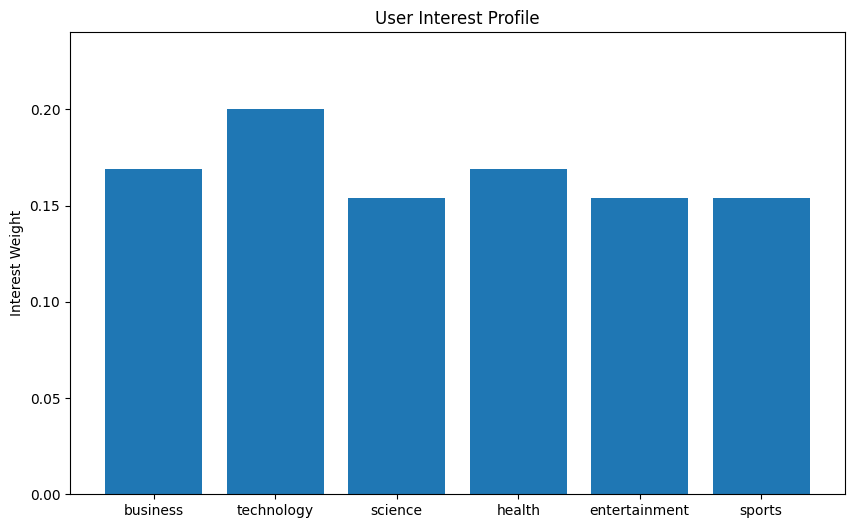


--- Interactive recommendation explorer ---
Adjust sliders to see how recommendation balance changes


interactive(children=(IntSlider(value=30, description='Diversity Weight (%):', step=5), IntSlider(value=40, de…

In [11]:
from ipywidgets import interact, widgets

def interactive_recommendation_demo(articles_df, user):
    """Interactive demo with sliders to adjust recommendation parameters"""

    def update_recommendations(diversity_weight, content_weight):
        # Get recommendations with current weights
        recommendations = enhanced_recommend_articles(
            articles_df, user, num_recommendations=5,
            diversity_weight=diversity_weight/100,
            content_weight=content_weight/100)

        # Display recommendations
        display_enhanced_recommendations(recommendations)

        # Analyze diversity
        analyze_recommendation_diversity(recommendations)

        return recommendations

    # Create interactive widgets
    interact(
        update_recommendations,
        diversity_weight=widgets.IntSlider(min=0, max=100, step=5, value=30,
                                          description='Diversity Weight (%):'),
        content_weight=widgets.IntSlider(min=0, max=100, step=5, value=40,
                                        description='Content Weight (%):')
    )

# Function to run the complete demo with the interactive component
def run_complete_news_curator_demo():
    """Run the complete demo including the interactive component"""
    # Create a user profile
    user = UserProfile(user_id='demo_user')

    # Fetch news articles
    print("Fetching news articles...")
    articles = fetch_news()

    if articles.empty:
        print("No articles found. Please check your API key.")
        return

    # Simulate user reading history
    print("\n--- Creating simulated user reading history ---")
    # Read 3 technology articles
    tech_articles = articles[articles['category'] == 'technology'].head(3)
    for i, article in tech_articles.iterrows():
        user.record_article_read(i, 'technology')

    # Read 1 business article
    business_article = articles[articles['category'] == 'business'].iloc[0]
    user.record_article_read(business_article.name, 'business')

    # Read 1 health article
    health_article = articles[articles['category'] == 'health'].iloc[0]
    user.record_article_read(health_article.name, 'health')

    # Display user profile
    print("\n--- User interest profile after simulated reading ---")
    print(user.get_interest_profile())
    plot_interest_profile(user)

    # Launch interactive demo
    print("\n--- Interactive recommendation explorer ---")
    print("Adjust sliders to see how recommendation balance changes")
    interactive_recommendation_demo(articles, user)

# Run the complete demo
run_complete_news_curator_demo()

**Saving User Profiles and Recommendations for Future Use**

In [15]:
def save_user_profile(user, filename='user_profile.json'):
    """Save user profile to a JSON file"""
    user_data = {
        'user_id': user.user_id,
        'interests': user.interests,
        'read_articles': user.read_articles
    }

    with open(filename, 'w') as f:
        json.dump(user_data, f)

    print(f"User profile saved to {filename}")

def load_user_profile(filename='user_profile.json'):
    """Load user profile from a JSON file"""
    try:
        with open(filename, 'r') as f:
            user_data = json.load(f)

        user = UserProfile(user_id=user_data['user_id'])
        user.interests = user_data['interests']
        user.read_articles = user_data['read_articles']

        print(f"User profile loaded from {filename}")
        return user
    except:
        print(f"Could not load profile from {filename}. Creating new profile.")
        return UserProfile(user_id='new_user')

# Example of saving and loading a user profile
def demo_profile_persistence():
    """Demonstrate saving and loading user profiles"""
    # Create and update a user profile
    user = UserProfile(user_id='persistent_user')
    user.update_interest('technology', 0.5)
    user.update_interest('health', 0.3)

    # Save the profile
    save_user_profile(user, 'demo_user.json')

    # Load the profile
    loaded_user = load_user_profile('demo_user.json')

    # Verify it worked
    print("\nVerifying loaded profile:")
    print(f"User ID: {loaded_user.user_id}")
    print(f"Interests: {loaded_user.interests}")

# Run the persistence demo
demo_profile_persistence()

User profile saved to demo_user.json
User profile loaded from demo_user.json

Verifying loaded profile:
User ID: persistent_user
Interests: {'business': 1.0, 'technology': 1.5, 'science': 1.0, 'health': 1.3, 'entertainment': 1.0, 'sports': 1.0}


**Final Run - Putting It All Together**

====== Personalized News Curator: Full Experience ======
Could not load profile from news_curator_user.json. Creating new profile.

Fetching today's news articles...

--- Current User Interest Profile ---
{'business': 0.16666666666666666, 'technology': 0.16666666666666666, 'science': 0.16666666666666666, 'health': 0.16666666666666666, 'entertainment': 0.16666666666666666, 'sports': 0.16666666666666666}


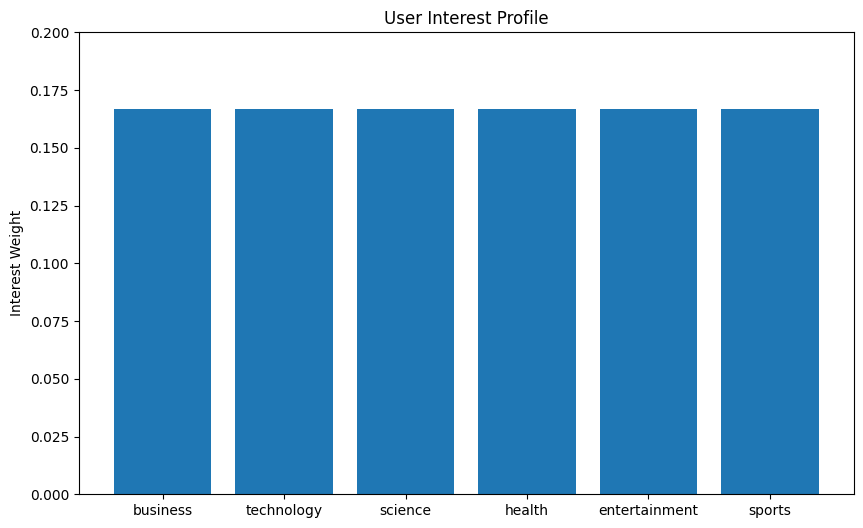


--- Today's Personalized News Recommendations ---
[BUSINESS] More alternatives to knee replacement surgery are emerging - The Washington Post
Relevance: 0.17, Diversity: 0.83, Content Similarity: 0.50
→ https://www.washingtonpost.com/health/2025/05/11/knee-arthritis-replacement-nerves-ablation/

[BUSINESS] Trump's trade war is giving renewed importance to advertising Upfronts - CNBC
Relevance: 0.17, Diversity: 0.83, Content Similarity: 0.50
→ https://www.cnbc.com/2025/05/11/advertising-upfronts-trump-trade-renewed-importance.html

[BUSINESS] Coinbase aims to become the No. 1 financial service app in the world in 10 years, CEO says - CNBC
Relevance: 0.17, Diversity: 0.83, Content Similarity: 0.50
→ https://www.cnbc.com/2025/05/11/coinbase-aims-to-be-worlds-number-1-financial-service-app-in-10-years.html

[BUSINESS] Reporter Unravels Why His Cancer Drug Costs So Much - Newser
Relevance: 0.17, Diversity: 0.83, Content Similarity: 0.50
→ https://www.newser.com/story/368385/reporter-unrave

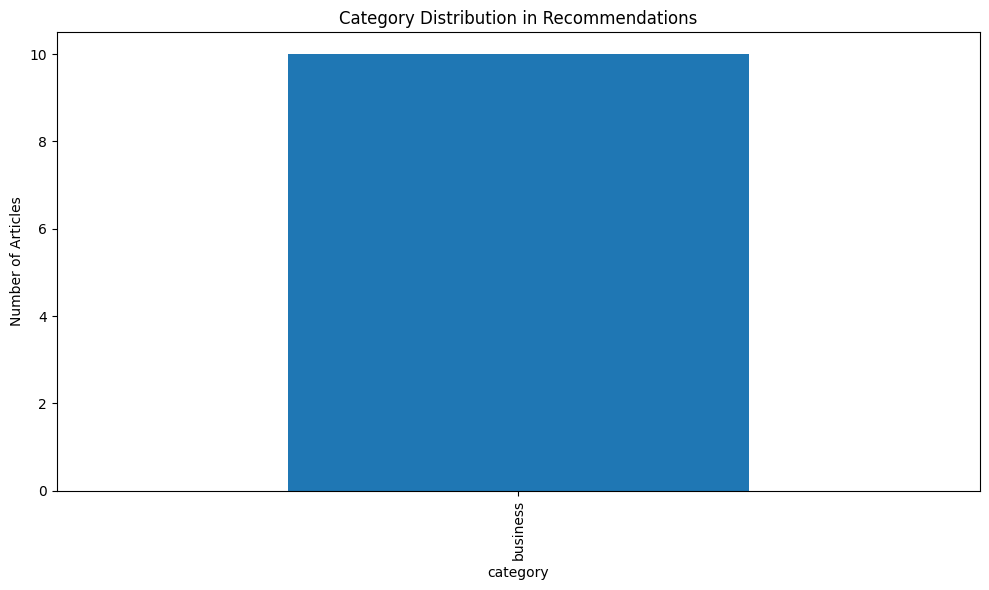


--- Simulating User Reading Articles ---
Reading: More alternatives to knee replacement surgery are emerging - The Washington Post (business)
Reading: Trump's trade war is giving renewed importance to advertising Upfronts - CNBC (business)
Reading: Coinbase aims to become the No. 1 financial service app in the world in 10 years, CEO says - CNBC (business)

--- Updated User Interest Profile ---
{'business': 0.20634920634920637, 'technology': 0.15873015873015872, 'science': 0.15873015873015872, 'health': 0.15873015873015872, 'entertainment': 0.15873015873015872, 'sports': 0.15873015873015872}


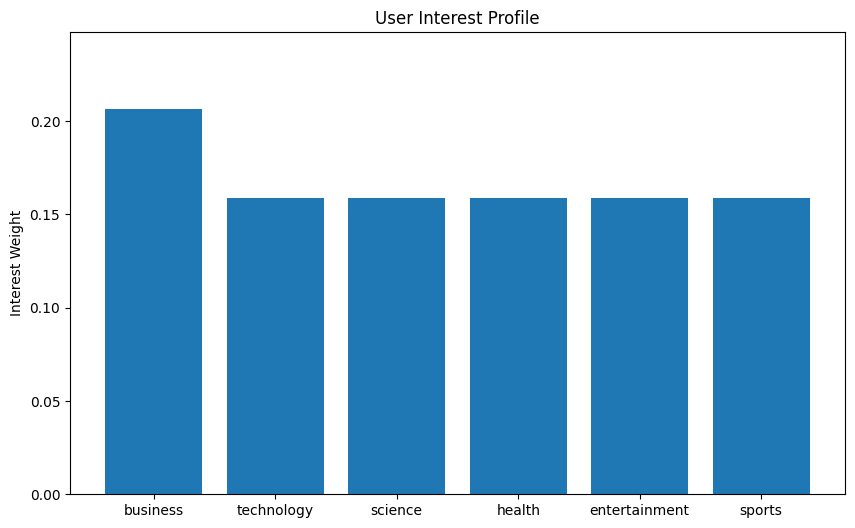


--- Updated Recommendations After Reading ---
[TECHNOLOGY] I've had T-Mobile for 10 years, but I just canceled my account. Here's why - Android Authority
Relevance: 0.16, Diversity: 0.84, Content Similarity: 0.11
→ https://www.androidauthority.com/canceled-t-mobile-after-10-years-why-3555297/

[SPORTS] Dave Martinez makes his feelings known after Nationals’ skid hits four - The Washington Post
Relevance: 0.16, Diversity: 0.84, Content Similarity: 0.10
→ https://www.washingtonpost.com/sports/2025/05/10/nationals-cardinals-losing-streak/

[BUSINESS] Trump’s pro-crypto stance splits congress: Why & what next? - AMBCrypto
Relevance: 0.21, Diversity: 0.79, Content Similarity: 0.09
→ https://ambcrypto.com/trumps-pro-crypto-stance-splits-congress-why-what-next/

[BUSINESS] Washington mother, 78, dies after eating mislabeled cookie — as family takes action against supermarket - New York Post
Relevance: 0.21, Diversity: 0.79, Content Similarity: 0.07
→ https://nypost.com/2025/05/11/us-news/was

In [16]:
def run_full_news_curator_experience():
    """Run a complete simulation of using the news curator over time"""
    print("====== Personalized News Curator: Full Experience ======")

    # 1. Try to load existing user profile or create new one
    user = load_user_profile('news_curator_user.json')

    # 2. Fetch today's news
    print("\nFetching today's news articles...")
    articles = fetch_news()

    if articles.empty:
        print("No articles found. Please check your API key.")
        return

    # 3. Show current user interests
    print("\n--- Current User Interest Profile ---")
    print(user.get_interest_profile())
    plot_interest_profile(user)

    # 4. Generate personalized recommendations
    print("\n--- Today's Personalized News Recommendations ---")
    recommendations = enhanced_recommend_articles(
        articles, user, num_recommendations=10,
        diversity_weight=0.3, content_weight=0.4)

    display_enhanced_recommendations(recommendations)
    analyze_recommendation_diversity(recommendations)

    # 5. Simulate user reading some articles
    print("\n--- Simulating User Reading Articles ---")
    # Let's say user reads 3 recommended articles
    articles_to_read = recommendations.head(3)

    for i, article in articles_to_read.iterrows():
        print(f"Reading: {article['title']} ({article['category']})")
        user.record_article_read(i, article['category'])

    # 6. Show updated user profile
    print("\n--- Updated User Interest Profile ---")
    print(user.get_interest_profile())
    plot_interest_profile(user)

    # 7. Generate new recommendations based on updated profile
    print("\n--- Updated Recommendations After Reading ---")
    new_recommendations = enhanced_recommend_articles(
        articles, user, num_recommendations=5,
        diversity_weight=0.3, content_weight=0.4)

    display_enhanced_recommendations(new_recommendations)

    # 8. Save updated user profile
    save_user_profile(user, 'news_curator_user.json')

    print("\n====== News Curator Experience Complete ======")
    print("User profile saved for next session.")

# Run the full experience
run_full_news_curator_experience()